### Summary stats
```
Train on: LPL  
Val   on: LCK  
Test  on: LEC,LCS,PCS,VCS  
```

In [63]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
path_2020 = '../gcn/data/2020_LoL_esports_match_data_from_OraclesElixir_20201005.csv'
lol_2020 = pd.read_csv(path_2020)

In [8]:
worlds_major_regions_2020 = ['LEC','LPL','LCK','LCS','PCS','VCS']
games_2020= lol_2020[lol_2020['player'].isna()].groupby(['league']).nunique('gameid')['gameid']
games_2020[worlds_major_regions_2020].sort_values(ascending=False)

league
LPL    725
LCK    473
VCS    305
PCS    272
LCS    264
LEC    241
Name: gameid, dtype: int64

In [47]:
# is it valid to throw out non major region games?
# games_2020[~games_2020.index.isin(worlds_major_regions_2020)].sort_values(ascending=False)[:6]

In [16]:
lol_2019 = pd.read_csv('../gcn/data/2019_LoL_esports_match_data_from_OraclesElixir_20201005.csv')

/Users/alex/miniconda3/envs/gcn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
# not sure why this column is being weird (see error above)
# lol_2019['split'].unique()

In [49]:
worlds_major_regions_2019 = ['LEC','LPL','LCK','LCS','LMS','VCS']
games_2019 = lol_2019[lol_2019['player'].isna()].groupby(['league']).nunique('gameid')['gameid']
games_2019[worlds_major_regions_2019].sort_values(ascending=False)

league
LPL    640
LCK    483
VCS    337
LMS    265
LCS    231
LEC    227
Name: gameid, dtype: int64

### Model results

In [5]:
gcn = pd.read_csv('../gcn/logs/test_league_scores_gcn_1_layer_1_ahead_full.csv')

In [9]:
round(gcn['acc'].mean(),3), round(gcn['acc'].std(),5)

(0.529, 0.00911)

In [10]:
gcn_c = pd.read_csv('../gcn/logs/test_league_scores_gcn_c_1_layer_1_ahead_full.csv')

In [15]:
gcn_c.groupby(['layer_count','dropout']).mean()['acc'].reset_index().sort_values('acc',ascending=False)

,layer_count,dropout,acc
4,16,0.50,0.692487
6,32,0.25,0.691395
0,8,0.25,0.685728
3,16,0.25,0.685045
7,32,0.50,0.679538
1,8,0.50,0.663937
8,32,0.75,0.600215
5,16,0.75,0.591678
2,8,0.75,0.550865


In [16]:
gcn_c.groupby(['layer_count','dropout']).std()['acc']

layer_count  dropout
8            0.25       0.014108
             0.50       0.036316
             0.75       0.021271
16           0.25       0.019307
             0.50       0.029296
             0.75       0.031578
32           0.25       0.004454
             0.50       0.009034
             0.75       0.025417
Name: acc, dtype: float64

In [71]:
gcn_no_delta = pd.read_csv('../gcn/logs/test_league_scores_gcn_cheby_no_delta.csv')

In [72]:
gcn_no_delta['acc'].mean(), gcn_no_delta['acc'].std()

(0.5334074795246124, 0.01625715332423319)

In [73]:
gcn_1_deg = pd.read_csv('../gcn/logs/test_league_scores_gcn_cheby_degree_1.csv')

In [75]:
gcn_1_deg['acc'].mean(), gcn_1_deg['acc'].std(), 

(0.6763425022363663, 0.03610398992802066)

### leakage graph

In [17]:
two_one = pd.read_csv('../gcn/logs/test_league_scores_gcn_c_2_layer_1_ahead.csv')

In [23]:
two_two = pd.read_csv('../gcn/logs/test_league_scores_gcn_c_2_layer_2_ahead.csv')

In [19]:
two_three = pd.read_csv('../gcn/logs/test_league_scores_gcn_c_2_layer_3_ahead.csv')

In [27]:
layers = [
    (1,two_one['acc'].mean(), two_one['acc'].std()),
    (2,two_two['acc'].mean(), two_two['acc'].std()),
    (3,two_three['acc'].mean(), two_three['acc'].std()),
]

In [33]:
ll = pd.DataFrame(columns = ['look ahead','mean','std'], data = layers)

Text(0.5, 1.0, 'Model accuracy vs. Number of Games look ahead (2 hidden layers)')

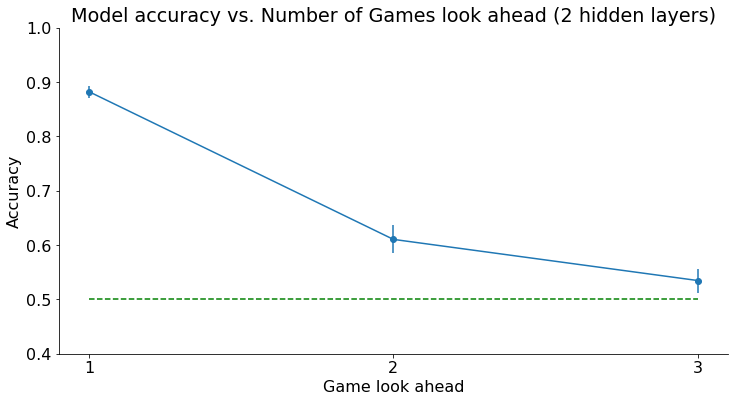

In [70]:
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(ll['look ahead'],ll['mean'])
ax.errorbar(ll['look ahead'],ll['mean'],yerr=ll['std'])
ax.hlines(0.5,1,3,colors=['green'],linestyles=['dashed'])
ax.set_ylim((0.4,1))
ax.set_xticks([1,2,3])
ax.set_xticklabels([1,2,3])
ax.set_xlabel('Game look ahead')
ax.set_ylabel('Accuracy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Model accuracy vs. Number of Games look ahead (2 hidden layers)') 
# (hidden layer size = 32, dropout = 0.25)

### Network visualization

In [1]:
from gcn.utils import *

In [4]:
adj, raw_features, y_train, y_val, y_test, train_mask, val_mask, test_mask, data_cols = load_data_lol(
    [path_2020],
    'delta',
    [['LPL'],['LCK'],['LCS']])

 
 Begin processing data... 



/Users/alex/miniconda3/envs/gcn/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/alex/miniconda3/envs/gcn/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/alex/miniconda3/envs/gcn/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

 
 Data processed 



### Visualize network

In [39]:
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
from scipy.sparse import csr_matrix,lil_matrix
import sys
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from math import floor

import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [61]:
raw_features.toarray().shape

(2926, 31)

In [16]:
adj_lpl_2020 = adj.toarray()[0:games_2020['LPL']*2,0:games_2020['LPL']*2]

In [17]:
G_lpl_2020 = nx.convert_matrix.from_numpy_matrix(adj_lpl_2020)

In [29]:
G = G_lpl_2020
pos_ = nx.spring_layout(G)

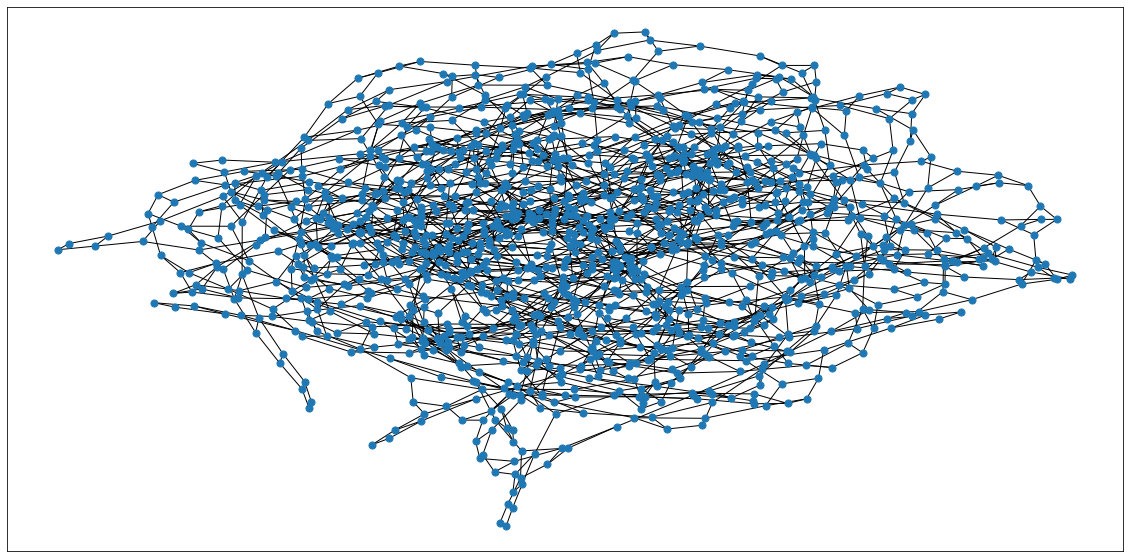

In [50]:
fig, ax = plt.subplots(figsize=(20,10))
nx.draw_networkx(G,pos_,node_size=50,with_labels=False,ax=ax)